In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [12]:
# =============
# -user config-
# =============
scanStep=1
height=12
detectLen=49.4
pointCnt=471
angleStart=35
angleStep=1
gridn=100

In [13]:
data = pd.read_csv("../data/dataExported.csv")
print(data)

         Frame  Beam  Point  Value
0            0     0      0    486
1            0     0      1    610
2            0     0      2    469
3            0     0      3    450
4            0     0      4    192
...        ...   ...    ...    ...
4723771    277    35    467    275
4723772    277    35    468    244
4723773    277    35    469    177
4723774    277    35    470    179
4723775    277    35    471    298

[4723776 rows x 4 columns]


低通滤除幅值较低的点

Flitered points count: 2565331


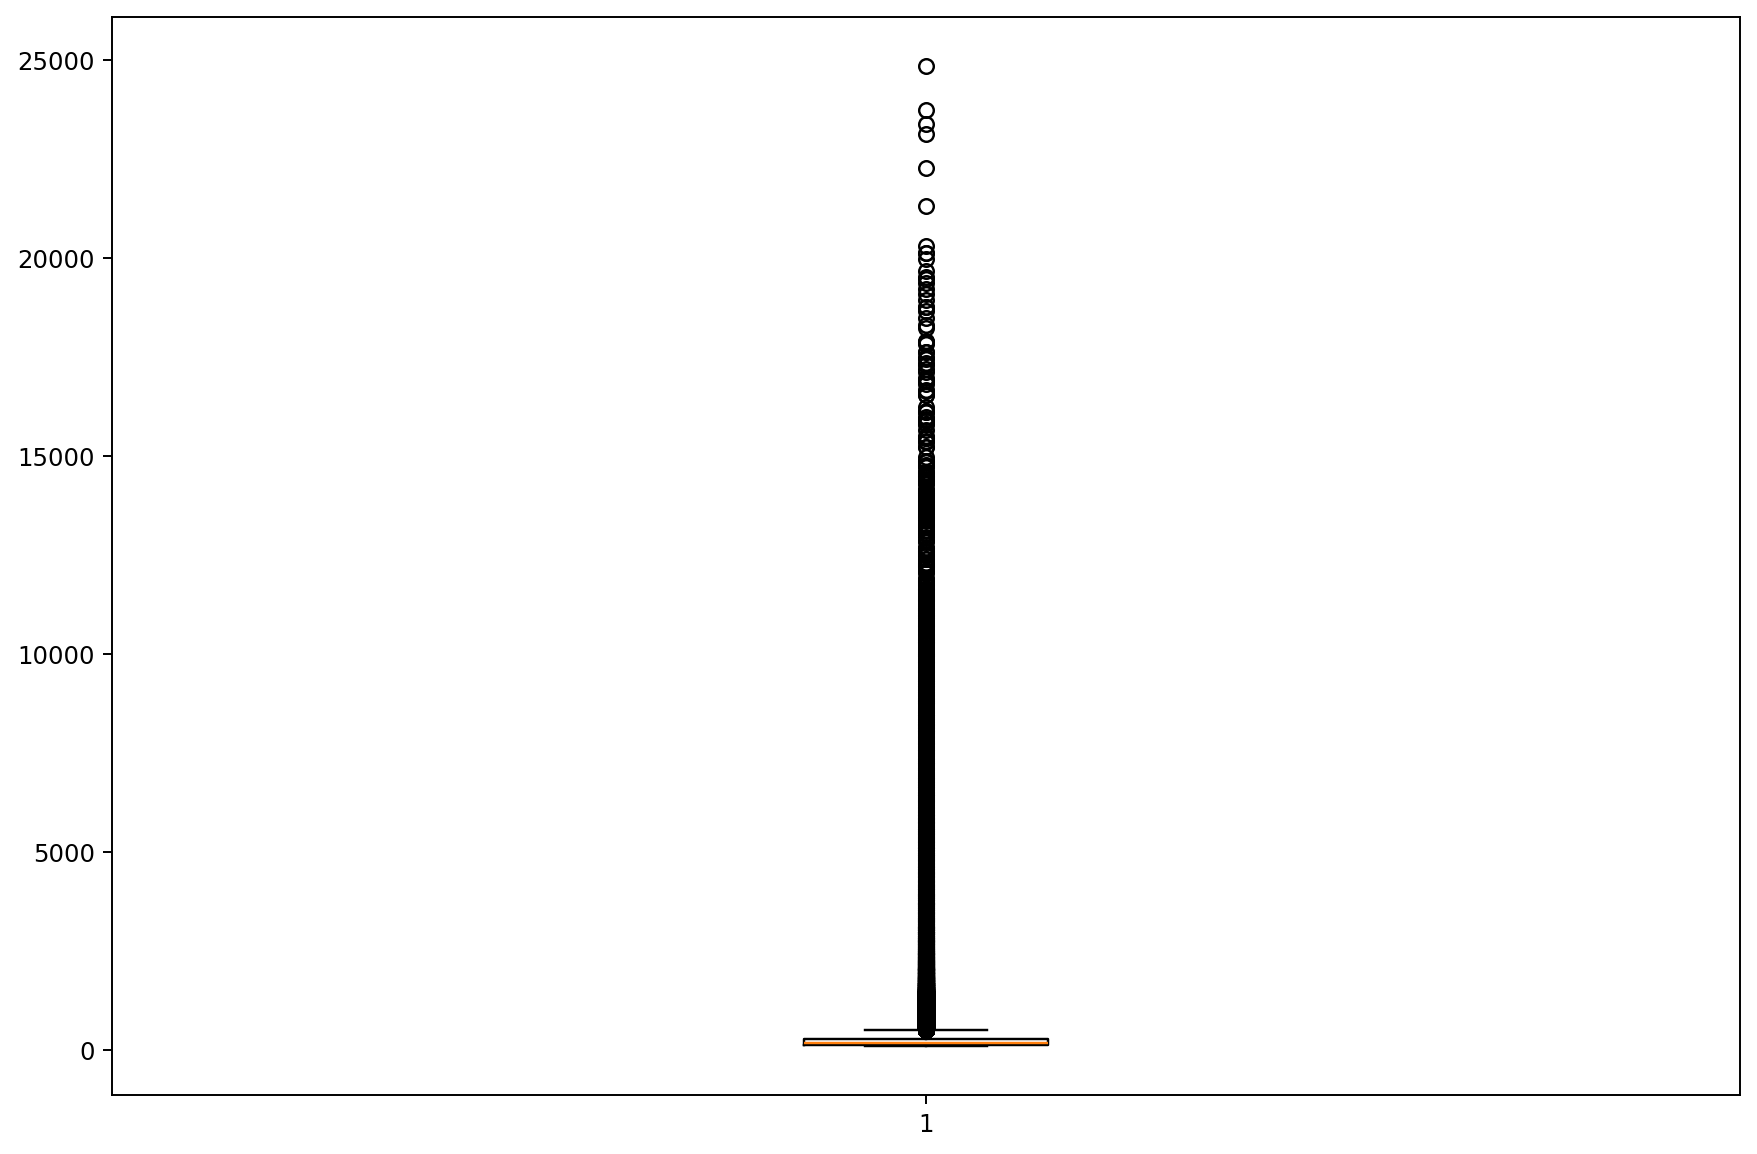

In [14]:
%matplotlib inline
data_high = data.loc[data['Value'] > 100]
print("Flitered points count: " + str(len(data_high)))
plt.boxplot(data_high['Value'])
plt.show()

原射线坐标系原生转换三维坐标系

In [15]:
def to3dAxes(frame, beam, point, reflection = True):
    x = frame * scanStep
    angleBeam = (angleStart + angleStep * beam) * math.pi / 180
    pointLen = detectLen * (point + 1) / pointCnt
    z = pointLen * np.sin(angleBeam)
    yFull = pointLen * np.cos(angleBeam)
    y = yFull
    if reflection == True:
        y = y % (2 * height)
        y[y > height] = 2 * height - y[y > height]
    return x, y, z



x, y, z = to3dAxes(data['Frame'].values, data['Beam'].values, data['Point'].values, reflection=False)
v = data['Value'].values
data_3d = pd.DataFrame({'x': x, 'y': y, 'z': z, 'value': v})
print(data_3d)
print(data_3d["value"].max())

           x          y          z  value
0          0   0.085915   0.060159    486
1          0   0.171831   0.120317    610
2          0   0.257746   0.180476    469
3          0   0.343661   0.240634    450
4          0   0.429577   0.300793    192
...      ...        ...        ...    ...
4723771  277  16.788179  46.125141    275
4723772  277  16.824051  46.223699    244
4723773  277  16.859923  46.322257    177
4723774  277  16.895795  46.420815    179
4723775  277  16.931667  46.519373    298

[4723776 rows x 4 columns]
24836


插值到点阵结构

In [16]:
%matplotlib inline
from scipy.interpolate import LinearNDInterpolator
from matplotlib.colors import LinearSegmentedColormap

def getGrid2D():
    axis = np.linspace(0, detectLen, num=gridn)
    return np.meshgrid(axis, axis)

def toGridData2D(y, z, value):
    # 生成对应grid数据
    yi = np.linspace(0, detectLen, num=gridn)
    zi = np.linspace(0, detectLen, num=gridn)
    yi, zi = np.meshgrid(yi, zi)
    interp = LinearNDInterpolator(list(zip(y, z)), value, fill_value=0)
    valuei = interp(yi, zi)
    return yi, zi, valuei

def drawAScan(x2d, y2d, value2d):
    my_color = [(0,'#FFFFFF'),(0.33,'#0000FF'),(0.66,'#00FF00'),(1,'#FF0000')]
    my_cmap = LinearSegmentedColormap.from_list('my_cmap', my_color)
    fig, ax = plt.figure(), plt.axes()
    im = ax.pcolormesh(x2d, y2d, value2d, shading='auto', cmap=my_cmap)
    ax.set(xlim=(0, detectLen), ylim=(0, detectLen))
    ax.invert_yaxis()
    fig.colorbar(im)
    plt.show(block=True)



# numpy 按frame存储的矩阵数组
data_clips = []

for frame in range(max(data_3d['x'].values) + 1):
    data_3df = data_3d.loc[data_3d['x']==frame, ['y', 'z', 'value']]
    yf, zf, vf = data_3df['y'].values, data_3df['z'].values, data_3df['value'].values
    yf_g, zf_g, vf_g = toGridData2D(yf, zf, vf)
    #drawAScan(zf_g, yf_g, vf_g)
    data_clips.append(np.array(vf_g))
    print("\rcurrent frame: {}".format(frame), end="")

print(len(data_clips))

Using matplotlib backend: QtAgg
current frame: 277278


均值衰减过滤结构噪声

In [17]:
def reductMean(matrixArr, a=0.9):
    if len(matrixArr) == 0:
        return None
    mean = np.zeros_like(matrixArr[0])
    reduc = np.zeros_like(matrixArr[0])
    for matrix in matrixArr:
        reduc = reduc * a + matrix
        mean = mean + reduc
    mean = mean / len(matrixArr)
    return mean



meanFrame = reductMean(data_clips)
print(meanFrame)
gridY, gridZ = getGrid2D()
drawAScan(gridZ, gridY, meanFrame)

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.         3367.45682177    0.         ...    0.
     0.            0.        ]
 [   0.         3340.80078376 3062.74074897 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


可视化三维散点图像

In [18]:
# TODO

In [42]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
colo = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
x = data_3d.loc[(data_3d["value"]>4000), ["x", "y", "z"]].to_numpy()
print(x)

fig = plt.figure(figsize=(20, 20))
ax3d = fig.add_axes(Axes3D(fig))

shape = x.shape
sse = []
score = []
K = 4 
clf = KMeans(n_clusters=K)
clf.fit(x)
sse.append(clf.inertia_)
lab = clf.fit_predict(x)
x = np.round(x, decimals=4)
print(x)
print(lab)
score.append(silhouette_score(x, clf.labels_, metric='euclidean'))
for i in range(shape[0]):
    ax3d.scatter(x[i][0], x[i][1], x[i][2], c=colo[lab[i]])
ax3d.set_xlabel('X label') # 画出坐标轴
ax3d.set_ylabel('Y label')
ax3d.set_zlabel('Z label')
# ax3d.invert_yaxis()
# ax3d.invert_zaxis()

plt.show()



[[  0.          31.30836262  36.01615124]
 [  0.          31.37717221  36.09530762]
 [  0.          30.6750257   36.55707208]
 ...
 [250.          17.68590129  37.92753772]
 [251.          18.34513445  37.61309964]
 [251.          17.68590129  37.92753772]]


d:\Program\Miniconda3\envs\GML\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Program\Miniconda3\envs\GML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Program\Miniconda3\envs\GML\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Program\Miniconda3\envs\GML\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows 

[[  0.      31.3084  36.0162]
 [  0.      31.3772  36.0953]
 [  0.      30.675   36.5571]
 ...
 [250.      17.6859  37.9275]
 [251.      18.3451  37.6131]
 [251.      17.6859  37.9275]]
[3 3 3 ... 2 2 2]
